# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'imread'

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

NameError: name 'load_CIFAR10' is not defined

## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time
# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
                                                                                                                                
# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))
print(grad)

[[ 0.05469225  0.11810526  0.09049883 ...,  0.09007099  0.11177995
   0.14116444]
 [ 0.07333854  0.11518648  0.09019045 ...,  0.11714854  0.08139217
   0.03821931]
 [ 0.1106597   0.09808897  0.09309577 ...,  0.08801578  0.10509689
   0.0864053 ]
 ..., 
 [ 0.07489628  0.08631219  0.09044988 ...,  0.10943938  0.08909325
   0.08617419]
 [ 0.09202358  0.11936724  0.08311073 ...,  0.09563845  0.06996348
   0.15123919]
 [ 0.08030152  0.13067897  0.08001895 ...,  0.08942852  0.13263599
   0.13635349]]
(500, 10) (500,) (500, 3073) (3073, 10)
loss: 2.338983
sanity check: 2.302585
[[ -3.73251223e+00  -3.28079587e-01   9.45147602e-01 ...,   7.42417091e-01
   -2.63153733e+00  -3.92800959e+00]
 [ -4.43876447e+00  -2.43168840e-02   4.84007926e-01 ...,   1.66650027e-01
   -4.45502481e+00  -4.10498595e+00]
 [ -6.38419504e+00   5.25513628e-01   2.56112633e+00 ...,  -3.92557657e-03
   -7.35678925e+00  -4.74167575e+00]
 ..., 
 [ -7.50547725e-01  -5.51688248e-01  -1.81979488e-01 ...,  -1.51554707e+00
    

## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [6]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.942489 analytic: -0.942490, relative error: 5.577754e-08
numerical: 2.479910 analytic: 2.479910, relative error: 2.532410e-08
numerical: 0.915981 analytic: 0.915981, relative error: 2.299076e-08
numerical: 1.282337 analytic: 1.282337, relative error: 1.697888e-08
numerical: -0.537464 analytic: -0.537464, relative error: 2.023964e-07
numerical: 0.219305 analytic: 0.219305, relative error: 1.800064e-08
numerical: 1.664475 analytic: 1.664474, relative error: 1.968372e-08
numerical: -0.238822 analytic: -0.238822, relative error: 1.375611e-07
numerical: -1.434182 analytic: -1.434182, relative error: 1.200957e-08
numerical: 1.308309 analytic: 1.308309, relative error: 5.352122e-09
numerical: -2.569678 analytic: -2.571875, relative error: 4.273643e-04
numerical: 3.454007 analytic: 3.452525, relative error: 2.146051e-04
numerical: 3.146960 analytic: 3.141954, relative error: 7.959146e-04
numerical: 0.864895 analytic: 0.850950, relative error: 8.127315e-03
numerical: 1.351956 anal

In [7]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.338983e+00 computed in 0.097615s
vectorized loss: 2.338983e+00 computed in 0.009738s
Loss difference: 0.000000
Gradient difference: 0.000000


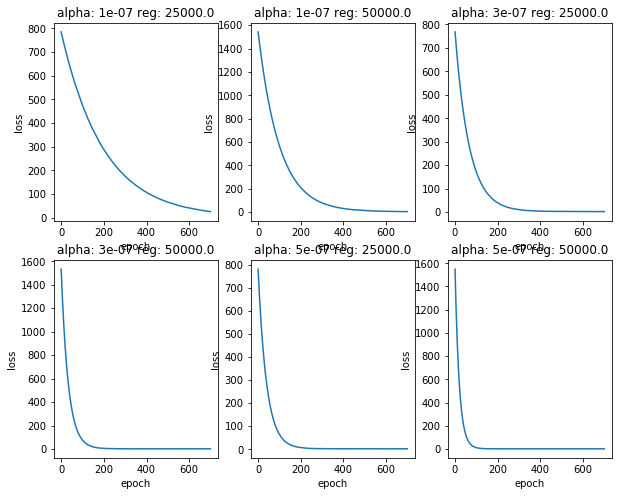

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.308061 val accuracy: 0.314000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.329510 val accuracy: 0.341000
lr 3.000000e-07 reg 2.500000e+04 train accuracy: 0.351612 val accuracy: 0.370000
lr 3.000000e-07 reg 5.000000e+04 train accuracy: 0.329265 val accuracy: 0.337000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.350898 val accuracy: 0.370000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.327143 val accuracy: 0.347000
best validation accuracy achieved during cross-validation: 0.370000


In [11]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7,3e-7,5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
loop = 700
plt.figure(1)
i = 1
for alpha in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        loss_history = softmax.train(X_train, y_train, alpha, reg, loop)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        acc_train = np.mean(y_train_pred == y_train)
        acc_val = np.mean(y_val_pred == y_val)
        results[(alpha, reg)] = (acc_train, acc_val)
        if acc_val > best_val:
            best_val = acc_val
            best_softmax = softmax
        plt.subplot(230 + i)
        plt.plot(loss_history)
        plt.title('alpha: ' + str(alpha) + ' reg: ' + str(reg))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        i += 1
plt.show()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)


In [12]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.362000


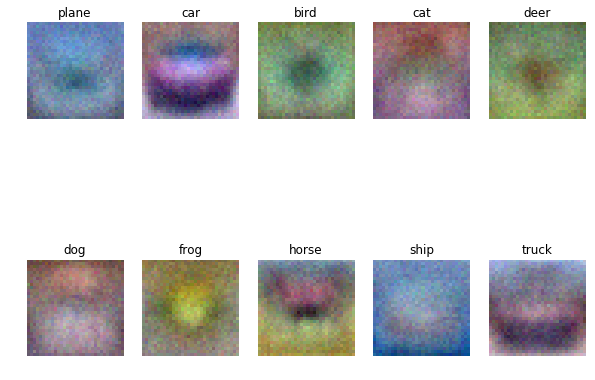

In [13]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])